In [1]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import seaborn as sns
from matplotlib.colors import LogNorm

print(pd.__version__)


2.2.3


In [2]:
# default colours
fr1  = '#344a9a'     # freiburg logo blue
fr1a = '#868dc2'     # freiburg logo blue (lighter)
fr1b = '#afb1d8'     # freiburg logo blue (lightest)
fr1c = '#00004a'     # freiburg logo blue (darker)
fr2  = '#93bc3c'     # ecosense green
fr2a = '#84a935'     # ecosense green (darker)
fr2b = '#558a06'     # ecosense green (darkest)
fr2c = '#bed789'     # ecosense green (lighter)
fr2d = '#c9de9d'     # ecosense green (lightest)
fr3  = '#00a082'     # freiburg teal
fr3a = '#33cfb2'     # freiburg teal (lighter)
fr4  = '#f5c2cd'     # freiburg pink
fr5  = '#ffe863'     # freiburg yellow
fr5a = '#fff1a1'     # freiburg yellow (lighter)
fr5b = '#e6d159'     # freiburg yellow (darker)
fr6  = '#8f6b30'     # freiburg brown
fr6a = '#d0bc9f'     # freiburg brown (lighter)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"

Change sensor number:

In [68]:
path = r"../data"

sensor = 1

file = f"/Sensor{sensor}_preprocessed_normed.csv"
df_all = pd.read_csv(path+file, delimiter=",")
df_all = df_all[(df_all["wavelength"] >= 390) & (df_all["wavelength"] <= 1100)]

In [69]:
channels = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "clear", "nir"]

In [70]:
X_train = df_all[channels]
y_train = df_all["PAR"]

In [71]:
components = np.arange(1,len(channels)+1)

In [72]:
xticks = np.arange(1,len(channels)+1)

In [73]:
# Plot the mses
def plot_metrics(vals, ylabel, objective, axs):
    with plt.style.context('ggplot'):
        axs.plot(xticks, np.array(vals), '-v', color=fr1, mfc=fr1)
        if objective=='min':
            idx = np.argmin(vals)
        else:
            idx = np.argmax(vals)
        axs.plot(xticks[idx], np.array(vals)[idx], 'P', ms=10, mfc='red')

        axs.set_xlabel('Number of PLS components')
        axs.set_xticks = xticks
        axs.set_ylabel(ylabel)
        axs.set_title('PLS')

    #plt.show()
    return idx+1

In [74]:
r2s = []
rmses = []
mapes = []

for n_comp in components:
    pls = PLSRegression(n_components=n_comp)
    y_pred = cross_val_predict(pls, X_train, y_train, cv=10)

    # Calculate scores
    r2s.append(r2_score(y_train, y_pred))
    mse = mean_squared_error(y_train, y_pred)
    rmses.append(np.sqrt(mse))

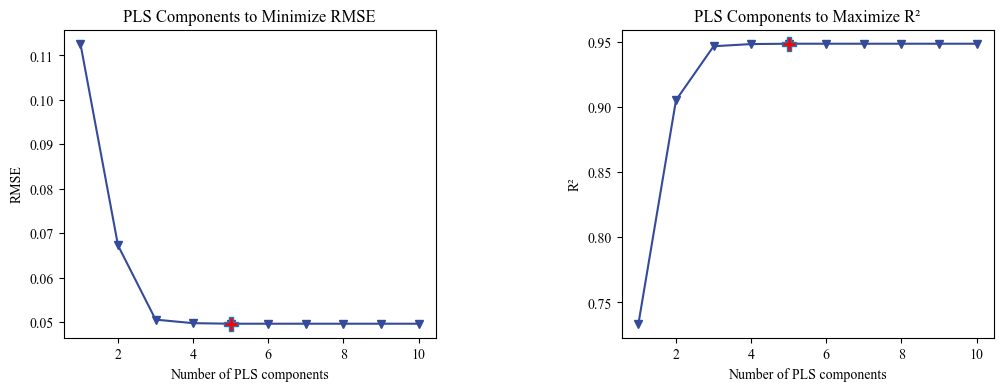

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.5)
min_rmse = plot_metrics(rmses, 'RMSE', 'min', axes[0])
axes[0].set_title('PLS Components to Minimize RMSE')
max_r2 = plot_metrics(r2s, 'R²', 'max', axes[1])
axes[1].set_title('PLS Components to Maximize R²')

plt.show()

In [76]:
print('CV: R2: %0.4f, RMSE: %0.8f' %(r2s[max_r2-1], rmses[max_r2-1]))

print("Minimum root mean squared error is reach with %d PLS components" %(max_r2))

CV: R2: 0.9483, RMSE: 0.04961216
Minimum root mean squared error is reach with 5 PLS components


Execute the PLS with the number of components that result in the smallest rmse on training data


In [77]:
pls2 = PLSRegression(n_components=max_r2)
pls2.fit(X_train, y_train)

PLSRegression(n_components=np.int64(5))

#### Transforming the data


In [78]:
vmin = 1e-16  # Lower bound
vmax = 1      # Upper bound

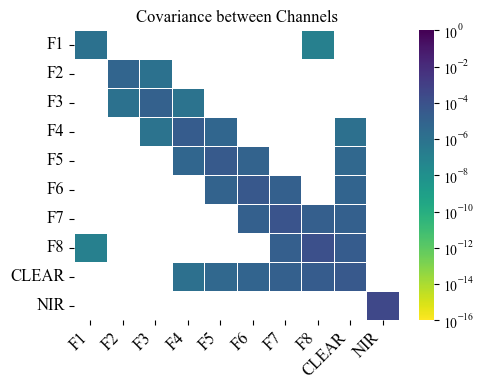

In [79]:
cov_of_X = np.cov(X_train.T, bias=True)
channels2 = ["F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "CLEAR", "NIR"]

plt.figure(figsize=(5,4))
sns.heatmap(cov_of_X, norm=LogNorm(vmin=vmin, vmax=vmax),cmap=sns.color_palette("viridis_r", as_cmap=True), cbar=True, linewidths=0.5, linecolor='white')
plt.title('Covariance between Channels')
plt.xticks(ticks=np.arange(len(channels)) + 0.5, labels=channels2, rotation=45, ha='right', fontsize=12)
plt.yticks(ticks=np.arange(len(channels)) + 0.5, labels=channels2, rotation=0, fontsize=12)
plt.tight_layout()

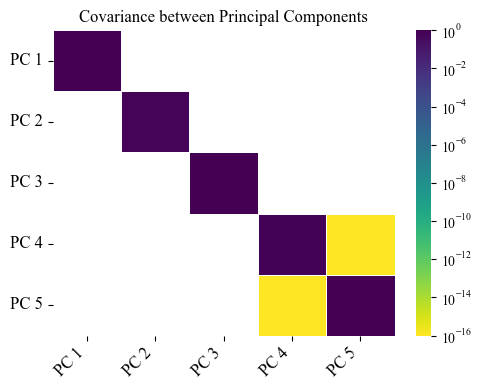

In [80]:
cov_of_X_scores = np.cov(pls2.x_scores_.T, bias=True)

plt.figure(figsize=(5,4))
sns.heatmap(cov_of_X_scores, norm=LogNorm(vmin=vmin, vmax=vmax),cmap=sns.color_palette("viridis_r", as_cmap=True), cbar=True, linewidths=0.5, linecolor='white')
plt.title('Covariance between Principal Components')
labels = [f'PC {i}' for i in range(1, min_rmse + 1)]
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=45, ha='right', fontsize=12)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels, rotation=0, fontsize=12)
plt.tight_layout()

#### Predicting the data

In [81]:
coefficients = pls2.coef_

for label, coef in zip(channels, coefficients.flatten()):
    print(f"{label}:\t{coef}")

f1:	59.92668374214957
f2:	24.707187929688796
f3:	21.507661710757734
f4:	17.24354494676951
f5:	13.39451791598263
f6:	11.814951899759546
f7:	12.42065147128524
f8:	10.469003281065792
clear:	-4.170943324622657
nir:	0.40111008526302516


In [82]:
coefficients

array([[59.92668374, 24.70718793, 21.50766171, 17.24354495, 13.39451792,
        11.8149519 , 12.42065147, 10.46900328, -4.17094332,  0.40111009]])

In [83]:
print(f"Intercept:\t"+str(pls2.intercept_))

Intercept:	[0.18529127]
